<a href="https://colab.research.google.com/github/cinthiaa/nav_aut_final_proj/blob/main/behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Se agregan las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import os

In [2]:
#se importan el dataset y el csv log desde el repo en github
!git clone https://github.com/cinthiaa/nav_aut_final_proj.git nav_aut_final_proj

Cloning into 'nav_aut_final_proj'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (391/391), done.
remote: Compressing objects: 100% (388/388), done.
remote: Total 391 (delta 0), reused 384 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (391/391), 26.10 MiB | 27.44 MiB/s, done.


In [3]:
import glob

DATASET_PATH = "/content/nav_aut_final_proj/data_beh_clon"

#Se obtienen los paths a las imagenes
IMAGES_PATH = os.path.join(DATASET_PATH, "captured_images/*.png")
captured_images = glob.glob(IMAGES_PATH, recursive=True)

#Se carga el csv a un df de pandas
LOG_PATH = os.path.join(DATASET_PATH, 'driving_log.csv')
steering_data = pd.read_csv(LOG_PATH)

steering_data.head()

,image_name,steering_angle
0,20250619_233401_298416.png,-0.015053
1,20250619_233401_814587.png,-0.000016
2,20250619_233402_315103.png,-0.000300
3,20250619_233402_815161.png,-0.017981
4,20250619_233403_319056.png,-0.005529


In [4]:
steering_data.dtypes

,0
image_name,object
steering_angle,float64


In [5]:
captured_images[0]

'/content/nav_aut_final_proj/data_beh_clon/captured_images/20250619_233511_204411.png'

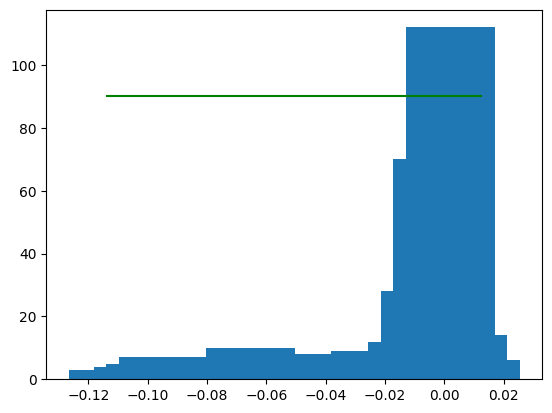

In [6]:
# Se observa la distribucion de los datos
num_bins = 30

samples_per_bin = 90

hist, bins = np.histogram(steering_data['steering_angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.03)
plt.plot((np.min(steering_data['steering_angle']), np.max(steering_data['steering_angle'])), (samples_per_bin, samples_per_bin), color = 'g')

In [7]:
# Se cargan imagenes y obtienen los conjuntos X y Y
X= []
y = []

for path in captured_images:
    file_name = os.path.basename(path)  # solo el nombre del archivo
    row = steering_data[steering_data["image_name"] == file_name]

    # Leer imagen
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X.append(img)

    # Obtener ángulo correspondiente
    angle = float(row["steering_angle"].values[0])
    y.append(angle)

# Convertir a numpy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [8]:
#Separacion de conjunto train y test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)} | Validation size: {len(X_val)}")

Train size: 301 | Validation size: 76


Text(0.5, 1.0, 'Validation set')

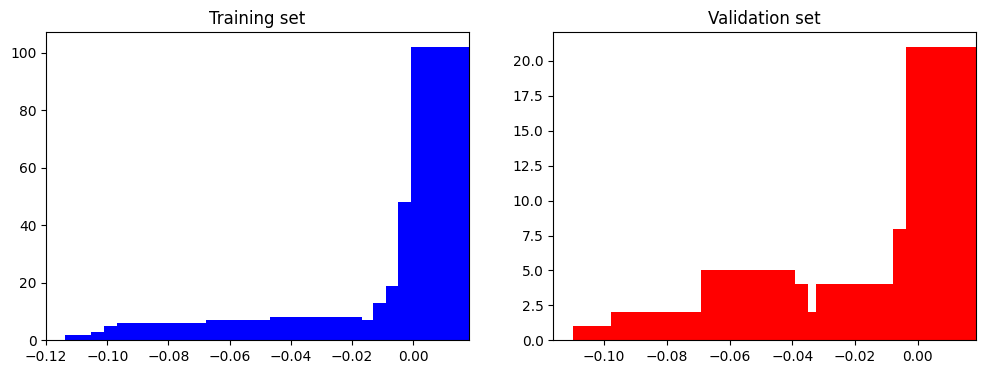

In [9]:
#Se observa la distribución de los conjuntos de train y test
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.03, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_val, bins=num_bins, width=0.03, color='red')
axes[1].set_title('Validation set')

# Data augmentation

In [10]:
"""Funcion para hacer zoom, recibe la imagen, el angulo y el factor de redimension. Regresa la imagen y el angulo (se mantiene)"""
def zoom(image, steering_angle, zoom_factor=1.0):
    """
    Aplica zoom sobre la imagen.

    - Si zoom_factor < 1.0 → acercamiento (crop + resize)
    - Si zoom_factor > 1.0 → alejamiento (resize + pad)
    """
    height, width = image.shape[0], image.shape[1]

    if zoom_factor < 1.0:
        # Zoom in: recorta el centro
        image = tf.image.central_crop(image, central_fraction=zoom_factor)
        image = tf.image.resize(image, [height, width])

    elif zoom_factor > 1.0:
        # Zoom out: escalar y colocar en lienzo negro del tamaño original
        new_height = int(height * zoom_factor)
        new_width = int(width * zoom_factor)

        # Redimensionar imagen más grande
        zoomed = tf.image.resize(image, [new_height, new_width])

        # Recortar para centrar dentro del canvas
        offset_y = (new_height - height) // 2
        offset_x = (new_width - width) // 2
        image = tf.image.crop_to_bounding_box(zoomed, offset_y, offset_x, height, width)

    # Si zoom_factor == 1.0, no se aplica nada
    return np.array(image), steering_angle



In [11]:
"""Funcion para modificar el brillo, recibe la imagen, el angulo. Regresa la imagen y el angulo (se mantiene)"""
def random_brightness(image, steering_angle):
    image = tf.image.random_brightness(image, max_delta=0.2)
    return np.array(image), steering_angle


In [12]:
"""Funcion para espejear gorizontalmente, recibe la imagen y el angulo. Regresa la imagen y el angulo con el signo invertido"""
def flip_horizontal(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return np.array(image), steering_angle


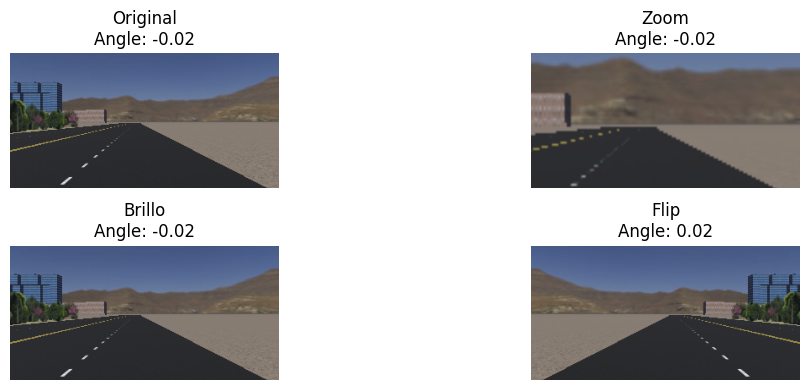

In [13]:
#Se prueban las funciones creadas con un ejemplo

img = X_train[218]  # suponiendo que X_train[0] es una imagen ya normalizada
angle = y_train[218]

# Probar zoom
img_zoomed, angle_zoomed = zoom(img, angle, zoom_factor=2.5)

# Probar brillo
img_bright, angle_bright = random_brightness(img, angle)

# Probar espejeo
img_flipped, angle_flipped = flip_horizontal(img, angle)

# Mostrar
plt.figure(figsize=(12, 4))
for i, (img_aug, title) in enumerate([
    (img, f"Original\nAngle: {angle:.2f}"),
    (img_zoomed, f"Zoom\nAngle: {angle_zoomed:.2f}"),
    (img_bright, f"Brillo\nAngle: {angle_bright:.2f}"),
    (img_flipped, f"Flip\nAngle: {angle_flipped:.2f}")
]):
    img_aug = img_aug / 255.0 # se normaliza para visualizar
    plt.subplot(2, 2, i+1)
    plt.imshow(img_aug)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [14]:
"""Funcion para aumentar las imagenes utilizando zoom, brillo y espejeo"""
def random_augment(image, steering_angle):
    # Flip horizontal con 50% de probabilidad
    if np.random.rand() < 0.5:
        image, steering_angle = flip_horizontal(image, steering_angle)

    # Zoom aleatorio
    if np.random.rand() < 0.5:
      zoom_factor = np.random.rand() + 0.6
      image, steering_angle = zoom(image, steering_angle, zoom_factor)

    # Brillo aleatorio
    if np.random.rand() < 0.5:
      image, steering_angle = random_brightness(image, steering_angle)

    return image, steering_angle


In [15]:
"""Funcion para el preprocesamiento"""
def img_preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0) #filtro Gaussiano para suavizar
    img = cv2.resize(img, (200, 66)) #Redimension a tamaño esperado por el modelo Nvidia
    img = img/255 #normalizacion
    return img


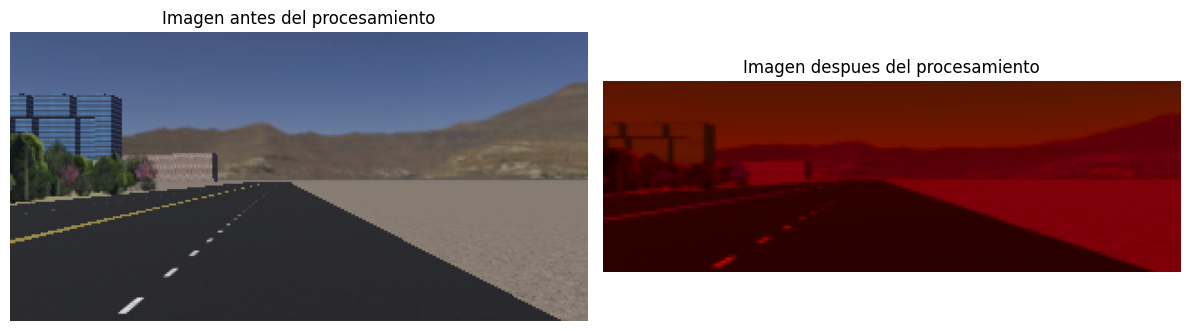

In [16]:
#Se prueban el preprocesameinto

img = X_train[218]

img_process = img_preprocess(img)

# Mostrar
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(img/255.0)
plt.title("Imagen antes del procesamiento")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_process)
plt.title("Imagen despues del procesamiento")
plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
"""Funcion batch_generator para aumentar las imagenes y aplicar el procesamiento durante el entrenamiento"""
def batch_generator(images, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):

            random_index = random.randint(0, len(images) - 1)

            if istraining:
                im, steering = random_augment(images[random_index], steering_ang[random_index])
            else:
                im = images[random_index]
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

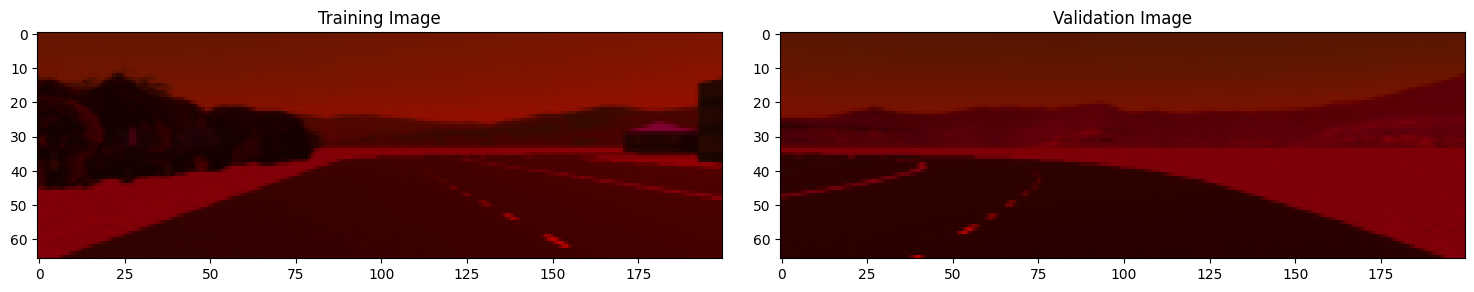

In [18]:
#Se visualiza la funcion batch_generator
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_val, y_val, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

# Definición del modelo y entrenamiento

In [19]:
 def nvidia_model():
    """Se define el modelo con la arquitectura propuesta por NVIDIA"""
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))

    model.add(Conv2D(64, (3, 3), activation='elu'))
    # model.add(tf.keras.layers.Dropout(0.5))


    model.add(Flatten())

    model.add(Dense(100, activation = 'elu'))

    model.add(Dense(50, activation = 'elu'))


    model.add(Dense(10, activation = 'elu'))


    model.add(Dense(1))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [20]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
#Se entrena el modelo utilizando la funcion batch_generator para aumentar el dataset
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=batch_generator(X_val, y_val, 100, 0),
                              validation_steps=200,
                              verbose=1)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 105s 325ms/step - loss: 0.0377 - val_loss: 4.1273e-04
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 95s 319ms/step - loss: 2.8255e-04 - val_loss: 3.6735e-04
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 141s 471ms/step - loss: 1.9649e-04 - val_loss: 3.6097e-04
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 142s 474ms/step - loss: 1.6141e-04 - val_loss: 3.7076e-04
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 143s 477ms/step - loss: 1.3192e-04 - val_loss: 4.0255e-04
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 142s 473ms/step - loss: 1.0606e-04 - val_loss: 3.8469e-04
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 87s 291ms/step - loss: 8.8488e-05 - val_loss: 3.7951e-04
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 90s 302ms/step - loss: 7.7394e-05 - val_loss: 4.5311e-04
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 305ms/step - loss: 6.9445e-05 - val_loss: 4.0969e-04
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 90s 300ms/step - loss: 5.4400e-05 - val_loss: 4.7929e-04


Text(0.5, 0, 'Epoch')

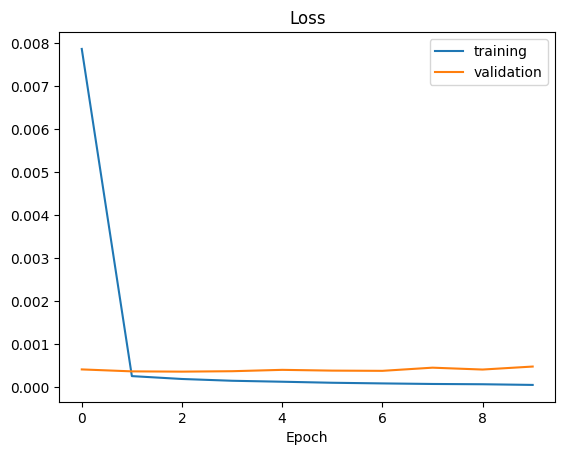

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [25]:
model.save('model.keras')